<a href="https://colab.research.google.com/github/mathfish/LearningTopics/blob/main/Books/PytorchMastery/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

## 1. Make Data

In [2]:
n_samnples = 1000
X_, y_ = make_circles(n_samples=n_samnples, noise=0.03, random_state=42)

print(f"First 5 samples of X:\n {X_[:5]}")
print(f"First 5 samples of y:\n {y_[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


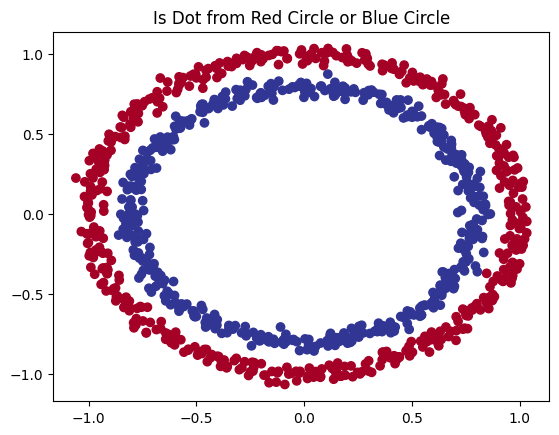

In [3]:
circles_df = pd.DataFrame({"X1": X_[:, 0], "X2": X_[:, 1]})

plt.scatter(circles_df.X1, circles_df.X2, c=y_, cmap=plt.cm.RdYlBu)
plt.title("Is Dot from Red Circle or Blue Circle");

In [4]:
# Turn data into tensors and create train and test splits

## change to default data type in pytorch, float32, vs what is numpy, float64
X = torch.from_numpy(X_).type(torch.float)
y = torch.from_numpy(y_).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

## 2. Build Classification Model

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# By hand to create custom model that handle more complex functionality if needed

class CircleModelV0(nn.Module):

  def __init__(self):
    super().__init__()
    # create 2 nn linear layers that can handle shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer 1 -> layer 2 -> output

# model_0 = CircleModelV0().to(device)

torch.manual_seed(42)
# This does the same thing as above. Note raw outputs are logits. Will need to apply sigmoid to get probabilities
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [7]:
# Setup loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss() # has sigmoid built it whereas BCEWithLoss() requires sigmoid to have been applied but this one is more stable
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return 100 * (correct / len(y_pred))


## 3. Train Model

In [8]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):

  model_0.train()
  # forward pass
  preds_logits = model_0(X_train).squeeze()
  preds_probs = torch.sigmoid(preds_logits)
  preds_labels = torch.round(preds_probs) # if >= .5 then 1 else 0
  # calc loss
  loss_ = loss_fn(preds_logits, y_train)
  accur_ = accuracy_fn(y_true=y_train, y_pred=preds_labels)
  # zero gradient
  optimizer.zero_grad()
  # back prop
  loss_.backward()
  # gradient
  optimizer.step()

  # predictions
  model_0.eval()
  with torch.inference_mode():
    preds_test_logits = model_0(X_test).squeeze()
    preds_test_probs = torch.sigmoid(preds_test_logits)
    preds_test_labels = torch.round(preds_test_probs)
    loss_test = loss_fn(preds_test_logits, y_test)
    accur_test = accuracy_fn(y_true=y_test, y_pred=preds_test_labels)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss_:.4f} | Train Accuracy: {accur_:.4f} | Test Loss: {loss_test:.4f} | Test ACcuracy: {accur_test:.4f}")

Epoch: 0 | Train Loss: 0.6957 | Train Accuracy: 50.0000 | Test Loss: 0.6972 | Test ACcuracy: 50.0000
Epoch: 10 | Train Loss: 0.6940 | Train Accuracy: 50.0000 | Test Loss: 0.6962 | Test ACcuracy: 50.0000
Epoch: 20 | Train Loss: 0.6934 | Train Accuracy: 46.0000 | Test Loss: 0.6959 | Test ACcuracy: 48.5000
Epoch: 30 | Train Loss: 0.6932 | Train Accuracy: 49.0000 | Test Loss: 0.6958 | Test ACcuracy: 47.5000
Epoch: 40 | Train Loss: 0.6931 | Train Accuracy: 49.5000 | Test Loss: 0.6957 | Test ACcuracy: 46.5000
Epoch: 50 | Train Loss: 0.6931 | Train Accuracy: 50.3750 | Test Loss: 0.6957 | Test ACcuracy: 46.5000
Epoch: 60 | Train Loss: 0.6931 | Train Accuracy: 50.5000 | Test Loss: 0.6956 | Test ACcuracy: 46.5000
Epoch: 70 | Train Loss: 0.6930 | Train Accuracy: 50.5000 | Test Loss: 0.6956 | Test ACcuracy: 46.5000
Epoch: 80 | Train Loss: 0.6930 | Train Accuracy: 50.7500 | Test Loss: 0.6955 | Test ACcuracy: 46.5000
Epoch: 90 | Train Loss: 0.6930 | Train Accuracy: 50.3750 | Test Loss: 0.6955 | Test

## 4. Make Predictions
Model does not seem to be learning. So we need to visualize to investigate


In [9]:
import requests
from pathlib import Path

# Download helper functions from Pytorch if not done already

if Path("helpter_functions.py").is_file():
  print("Helper file exists")
else:
  print("Downloading helper functions . . . ")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


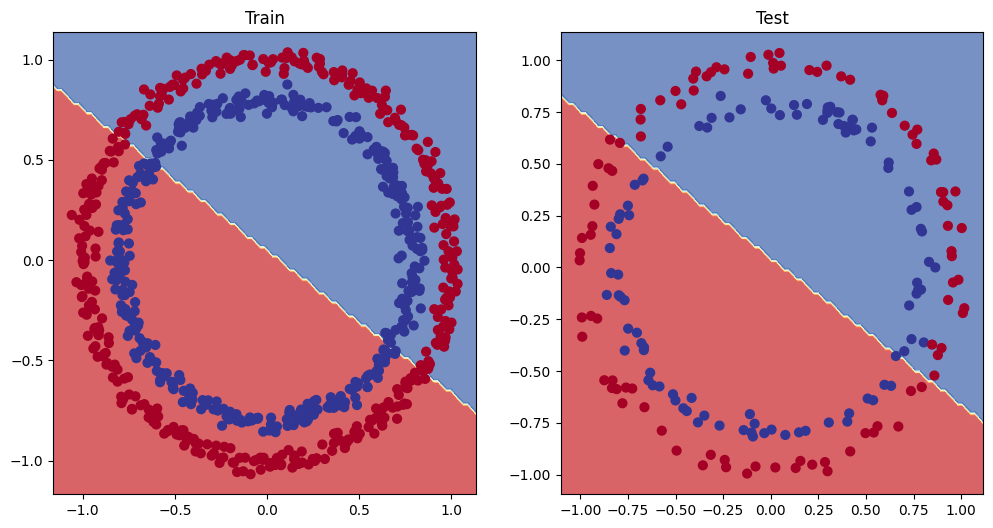

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving the Model
To potentially improve our model we can try:
* Add more layers
* Add more hidden units -> e.g. 5 to 10
* Fit for longer
* Change activation functions
* Change learning rate
* Change loss function

In [13]:
# Increased the number of hidden units and layers
class CircleModelV1(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # this way leverages speed ups by pytorch
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)

In [14]:
loss_fn_v1 = nn.BCEWithLogitsLoss()
optimizer_v1 = torch.optim.SGD(params=model_1.parameters(), lr=.1)

In [17]:
torch.manual_seed(42)

epochs = 1000
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  logits_ = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(logits_))

  loss_ = loss_fn_v1(logits_, y_train)
  accur_ = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer_v1.zero_grad()

  loss_.backward()

  optimizer_v1.step()

  model_1.eval()
  with torch.inference_mode():
    y_test_logits = model_1(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
    y_test_loss = loss_fn_v1(y_test_logits, y_test)
    y_test_accur = accuracy_fn(y_true=y_test, y_pred=y_test_pred)

  if epoch % 10 == 0:
     print(f"Epoch: {epoch} | Train Loss: {loss_:.4f} | Train Accuracy: {accur_:.4f} | Test Loss: {y_test_loss:.4f} | Test ACcuracy: {y_test_accur:.4f}")


Epoch: 0 | Train Loss: 0.6953 | Train Accuracy: 51.3750 | Test Loss: 0.6925 | Test ACcuracy: 50.5000
Epoch: 10 | Train Loss: 0.6945 | Train Accuracy: 50.7500 | Test Loss: 0.6923 | Test ACcuracy: 51.0000
Epoch: 20 | Train Loss: 0.6941 | Train Accuracy: 50.2500 | Test Loss: 0.6923 | Test ACcuracy: 50.5000
Epoch: 30 | Train Loss: 0.6938 | Train Accuracy: 49.3750 | Test Loss: 0.6923 | Test ACcuracy: 50.5000
Epoch: 40 | Train Loss: 0.6937 | Train Accuracy: 49.2500 | Test Loss: 0.6924 | Test ACcuracy: 50.5000
Epoch: 50 | Train Loss: 0.6935 | Train Accuracy: 48.8750 | Test Loss: 0.6924 | Test ACcuracy: 51.0000
Epoch: 60 | Train Loss: 0.6935 | Train Accuracy: 49.0000 | Test Loss: 0.6925 | Test ACcuracy: 50.5000
Epoch: 70 | Train Loss: 0.6934 | Train Accuracy: 48.7500 | Test Loss: 0.6926 | Test ACcuracy: 52.0000
Epoch: 80 | Train Loss: 0.6933 | Train Accuracy: 48.2500 | Test Loss: 0.6927 | Test ACcuracy: 52.5000
Epoch: 90 | Train Loss: 0.6933 | Train Accuracy: 48.5000 | Test Loss: 0.6928 | Test